### Importing Tensorflow, keras and Augmentor in the Environment

In [ ]:
!pip install tensorflow

!pip install keras

!pip install Augmentor

### Importing all the important libraries and Dataset

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, InputLayer

### **Data Reading/Data Understanding - Importing data from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Checking versions of Libraries
f'NumPy version: {np.__version__} | Pandas version: {pd.__version__} | keras version: {keras.__version__} | Tensorflow: {tf.__version__}'

'NumPy version: 1.22.4 | Pandas version: 1.5.3 | keras version: 2.12.0 | Tensorflow: 2.12.0'

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_Assignment/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_Assignment/Test')

In [ ]:
# Counting total no of images in dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Dataset Creation - Defining dataset**

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

**Image loading using keras.preprocessing**

Image to be loaded off from dataset by image_dataset_from_directory utility.

Splitting 80% of the data for training the model and 20% for validation segment.

In [ ]:
# segmenting the training dataset from dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode = "int",
  batch_size = batch_size,
  image_size = (img_height, img_width),
  seed = 123,
  subset = "training",
  validation_split = 0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# segmenting the validation dataset from dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode = "int",
  batch_size = batch_size,
  image_size = (img_height, img_width),
  seed = 123,
  subset = "validation",
  validation_split = 0.2
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Classify the types of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# Coutning no's of images in each class type of Train datset
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


In [ ]:
# Coutning no's of images in each class type of Test datset
for i in class_names:
  print(i,": ",len(list(data_dir_test.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  16
basal cell carcinoma :  16
dermatofibroma :  16
melanoma :  16
nevus :  16
pigmented benign keratosis :  16
seborrheic keratosis :  3
squamous cell carcinoma :  16
vascular lesion :  3


### **Data Visualization**

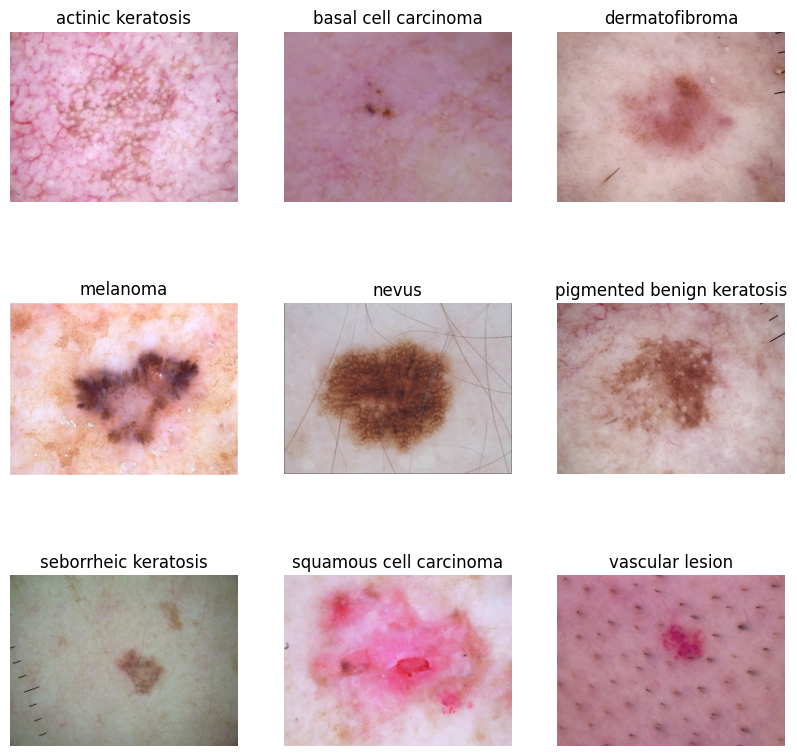

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for index,images in enumerate(class_names):

  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])
  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('off')
  plt.title(images)

In [ ]:
# Confirm the shape and size of Image
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


- The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB).

- The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Standardization of images**

The RGB channel values ranges in between 0 to 225, which is not good in case of neural network. Ideally it should be in between 0 and 1.

#### **There are two ways to use this Standardization.**
**Option 1 :** We can apply it to the dataset by calling Dataset.map i.e.,

*normalised_layer = tf.keras.layers.Rescaling(1./255)*

*normalized_dataset = train_dataset.map(lambda x, y: (normalised_layer(x), y))*

*image_batch, labels_batch = next(iter(normalized_dataset))*

**Option 2:** We can include the layer inside your model definition, which can simplify deployment

For this asignment, **option 2** is used for Standardization.

### **Model Building & Training**

### **Model 1 Creation**

First model to identify total 9 classes in dataset.

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9, activation='softmax')
])


### **Model 1 Compilation**

Using 'adam' as optimiser and 'CategoricalCrossentropy' as loss function to train the Model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### **Model 1 Summary**

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### **Training the Model 1**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 246s 932ms/step - loss: 1.9312 - accuracy: 0.2695 - val_loss: 1.7028 - val_accuracy: 0.3669
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5967 - accuracy: 0.4442 - val_loss: 1.6478 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4034 - accuracy: 0.5134 - val_loss: 1.4397 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3036 - accuracy: 0.5519 - val_loss: 1.3826 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1723 - accuracy: 0.5843 - val_loss: 1.3316 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2116 - accuracy: 0.5759 - val_loss: 1.4513 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.0814 - accuracy: 0.6161 - val_loss: 1.3453 - val_accuracy: 0.5660
Epoch 8/20

### **Visualizing training results for Model 1**

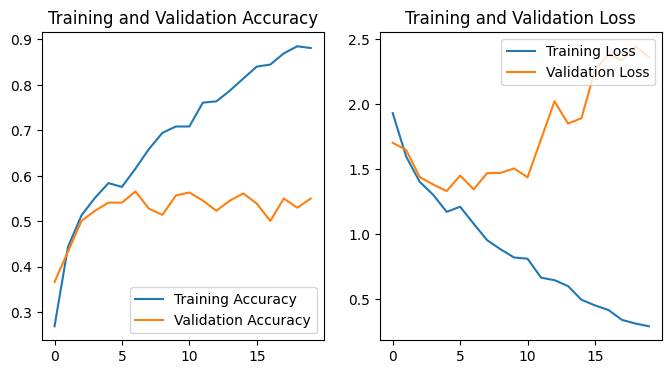

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**Findings:**

Train Data Accuracy : 0.8811

Train Loss : 0.293

Validation Data Accuracy : 0.5503

Validation Loss - 2.3615

**Nutshell:**

Accuracy figures indicates that model is highly overfit, secondly loss value of validation dataset is higher.

**Correction:**
Model need augmentation also dropout in layers.

### **Data Augmentation**
Augmentation is kind of apply flip, rotate, zoom for data input while model building, to enhance result.It is implemented using the following Keras preprocessing layers i.e., tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### **Building Model 2 after Augmentation**

In [ ]:
Augmented_data_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9, activation='softmax')
])

In [ ]:
#Compiling the model built after data augmentation
Augmented_data_model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Checking summary of Model built by augmenting data
Augmented_data_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
# Training model after data augmentation with 20 epoches
epochs = 30
history = Augmented_data_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 4s 33ms/step - loss: 2.2492 - accuracy: 0.1864 - val_loss: 2.0375 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 2s 31ms/step - loss: 2.0021 - accuracy: 0.2232 - val_loss: 1.8988 - val_accuracy: 0.2707
Epoch 3/30
56/56 [==============================] - 2s 32ms/step - loss: 1.7367 - accuracy: 0.3828 - val_loss: 1.6248 - val_accuracy: 0.4273
Epoch 4/30
56/56 [==============================] - 2s 31ms/step - loss: 1.5283 - accuracy: 0.4688 - val_loss: 1.4601 - val_accuracy: 0.5056
Epoch 5/30
56/56 [==============================] - 2s 31ms/step - loss: 1.4187 - accuracy: 0.5045 - val_loss: 1.5189 - val_accuracy: 0.4743
Epoch 6/30
56/56 [==============================] - 2s 29ms/step - loss: 1.3985 - accuracy: 0.5073 - val_loss: 1.4016 - val_accuracy: 0.5302
Epoch 7/30
56/56 [==============================] - 2s 29ms/step - loss: 1.3687 - accuracy: 0.5145 - val_loss: 1.5035 - val_accuracy: 0.5011
Epoch 8/30
56

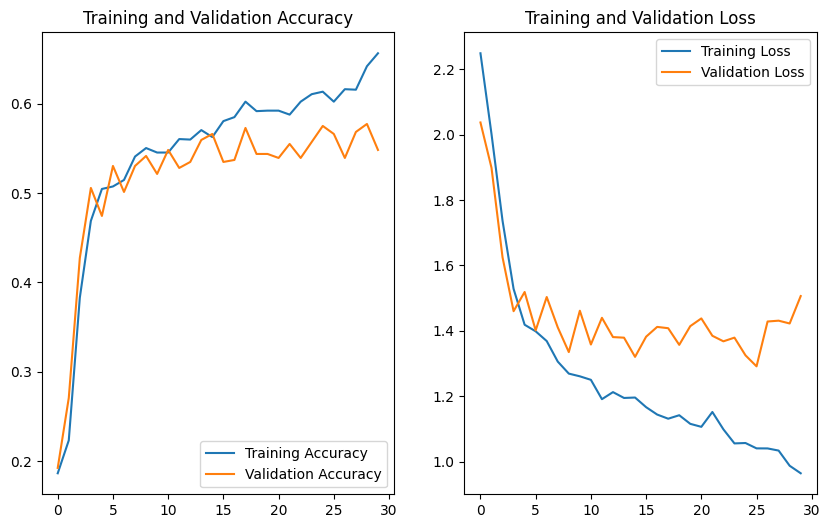

In [ ]:
# Visualizing the result
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Train Data Accuracy : 0.6562

Train Loss : 0.9642

Validation Data Accuracy : 0.5481

Validation Loss - 1.5064

**Nutshell:**

Accuracy figures indicates that model is less underfit compared to model 1.

**Correction:** Data imbalancing to be checked


## **Class distribution/Imbalance check**

In [ ]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


<BarContainer object of 9 artists>

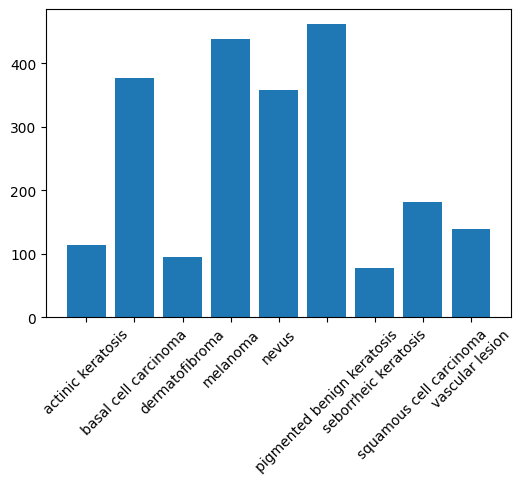

In [ ]:
# Visualize class imbalance through chart
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(6,4))
plt.xticks(rotation=45)
plt.bar(class_names,count)

**'seborrheic keratosis'** is having the least no of images i,e 77

**'pigmented benign keratosis'** is having the maximum no of images i,e 462

In [ ]:
# lebel checking
path_list=[]
lesion_list=[]
for i in class_names:
      for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNN_Assignment/Train/ac...,actinic keratosis
1,/content/drive/MyDrive/CNN_Assignment/Train/ac...,actinic keratosis
2,/content/drive/MyDrive/CNN_Assignment/Train/ac...,actinic keratosis
3,/content/drive/MyDrive/CNN_Assignment/Train/ac...,actinic keratosis
4,/content/drive/MyDrive/CNN_Assignment/Train/ac...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/CNN_Assignment/Train/va...,vascular lesion
2235,/content/drive/MyDrive/CNN_Assignment/Train/va...,vascular lesion
2236,/content/drive/MyDrive/CNN_Assignment/Train/va...,vascular lesion
2237,/content/drive/MyDrive/CNN_Assignment/Train/va...,vascular lesion


## **Augmentor Package**

A python package known as Augmentor is utilized to add more examples across all classes with the goal that none of the classes have not many examples.

Procedure to use Agumentor:

1. Start pipeline to folder of sample image
2. Mention no of operations to be done on pipline object.
3. Call the method

In [ ]:
import Augmentor
for i in class_names:
  augmnt_pipeline = Augmentor.Pipeline(str(data_dir_train) + '/'+ i)
  augmnt_pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  augmnt_pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x791F812047C0>: 100%|██████████| 500/500 [00:17<00:00, 29.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x791F813D48E0>: 100%|██████████| 500/500 [00:17<00:00, 29.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791F4B974EB0>: 100%|██████████| 500/500 [00:17<00:00, 27.95 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x791F812D7970>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x791F81355DE0>: 100%|██████████| 500/500 [01:36<00:00,  5.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x791F9C9AE200>: 100%|██████████| 500/500 [00:17<00:00, 28.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x791F1E3B8250>: 100%|██████████| 500/500 [00:41<00:00, 12.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791F4815EE00>: 100%|██████████| 500/500 [00:17<00:00, 28.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791F9E206950>: 100%|██████████| 500/500 [00:21<00:00, 23.46 Samples/s]


Augmentor has stored agumented images in the new subfolder output folder of each class folder. Lets have count for total.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## **Checking distribution of augmented data after adding new images to the original training data.**

In [ ]:
import os
import glob
from glob import glob

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-38-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## **Splitting Training dataset**

In [ ]:
augmented_data_dir = data_dir_train
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## **Segmenting Train and Validation set from dataset**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### **Building Model 3 After additional 500 images in output folder**

In [ ]:
# Include BatchNormalization, Dropout
Normalised_Model=Sequential()

Normalised_Model.add(InputLayer((180,180,3)))
Normalised_Model.add(Rescaling(1./255))

Normalised_Model.add(Conv2D(32, (3, 3), padding='same'))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Conv2D(32, (3, 3), padding='same'))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Conv2D(32, (3, 3), padding='same'))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Conv2D(64, (3, 3)))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Flatten())
Normalised_Model.add(Dense(512, activation='relu'))
Normalised_Model.add(Dense(256, activation='relu'))
Normalised_Model.add(Dropout(0.25))

Normalised_Model.add(Dense(9, activation='softmax'))


# having glance on layer summery
Normalised_Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)       

### **Compiling the Model 3 model built after after adding 500 additinal images with Adam optimiser**

In [ ]:
Normalised_Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### **Training the Model 3 built after after adding 500 additinal images with Augumentor package**

---

In [ ]:
epochs = 30
history = Normalised_Model.fit(
  train_dataset,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/30
169/169 [==============================] - 48s 247ms/step - loss: 1.9247 - accuracy: 0.3596 - val_loss: 2.6018 - val_accuracy: 0.1670
Epoch 2/30
169/169 [==============================] - 40s 232ms/step - loss: 1.3512 - accuracy: 0.4931 - val_loss: 1.9956 - val_accuracy: 0.2821
Epoch 3/30
169/169 [==============================] - 41s 236ms/step - loss: 1.1233 - accuracy: 0.5777 - val_loss: 1.1908 - val_accuracy: 0.5828
Epoch 4/30
169/169 [==============================] - 41s 237ms/step - loss: 0.9679 - accuracy: 0.6417 - val_loss: 1.0255 - val_accuracy: 0.6273
Epoch 5/30
169/169 [==============================] - 39s 225ms/step - loss: 0.7804 - accuracy: 0.7085 - val_loss: 1.2658 - val_accuracy: 0.5976
Epoch 6/30
169/169 [==============================] - 41s 239ms/step - loss: 0.6612 - accuracy: 0.7485 - val_loss: 1.0255 - val_accuracy: 0.6281
Epoch 7/30
169/169 [==============================] - 39s 225ms/step - loss: 0.5685 - accuracy: 0.7795 - val_loss: 0.7588 - val_ac

### **Visualizing the result**

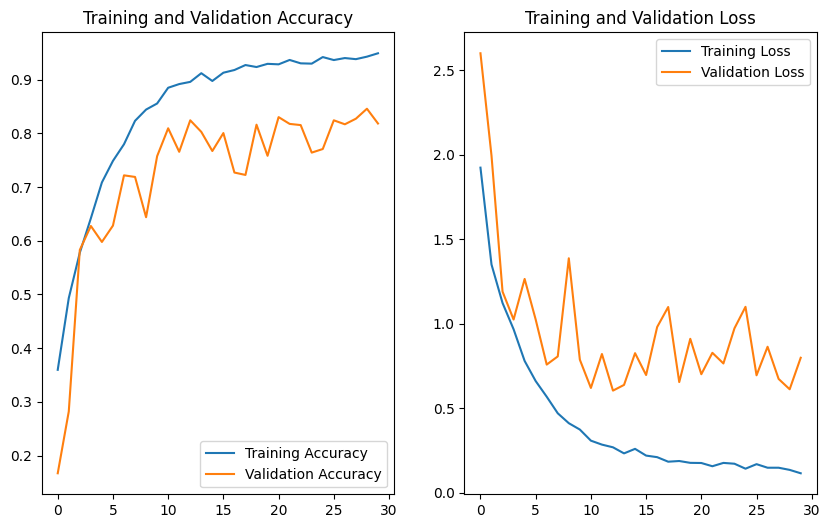

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Train Data Accuracy : 0.9488

Train Loss : 0.1153

Validation Data Accuracy : 0.8181

Validation Loss - 0.7992

**Nutshell:**

we can see that this model's validation accuracy is higher than earlier models. This model, however, is also overfitting.

Class rebalancing, droupout, and batch normalisation help achieve better results than a simple model.


**Correction:**

The Model can be further improved by tuning the hyperparameter.



# **Conclusion:**

## We observe gradual improvement from Model 1 to Model 3:

#**Model 1:** Simple CNN Model

## Accuracy: 0.8833 | Validation accuracy : 0.5278

#**Model 2:** Augmented data with droupout

## Accuracy: 0.6589 | Validation accuracy : 0.5256

#**Model 3:** Class rebalance,BatchNormalization with Dropout

## Accuracy: 0.9407 | Validation accuracy : 0.8377

# **The accuracy can still be incraesed using Hyper-Parameter tuning i.e., by exploring few different options like CNN configurations, loss functions, optimizers, and layer counts.**